Confronto sulle immagini del test set dei risultati de modelli principali per vedere quale ottiene risultati più simili alla maschera reale

In [1]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
from typing import Tuple

Segmentation Models: using `keras` framework.


In [2]:
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (0,0,0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [3]:

# loading image data...
def image_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path)
        image = resize_with_pad(image, (sx, sy)) #Mantengo la giusta proporzione e aggiungo del padding
        image_dataset.append(image)
    return image_dataset

In [4]:
# loading mask data...
def mask_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path, 0)
        image = resize_with_pad(image, (sx, sy))
        image_dataset.append(image)
    return image_dataset

In [5]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "car-segmentation", "images")
masks_folder = os.path.join("..", "car-segmentation", "masks")
n_classes = 5 # class for segmentation
size_x = 128
size_y = 128

#1) Immagine 128x128
image_dataset = image_loader(img_folder,size_x,size_y) # real images...
mask_dataset = mask_loader(masks_folder,size_x,size_y) # masked images...
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
#Espando la dimensione anche della maschera
mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)

#2) Immagine 144x144
size_x, size_y = 144,144
image_dataset_144 = image_loader(img_folder,size_x,size_y) # real images...
mask_dataset_144 = mask_loader(masks_folder,size_x,size_y) # masked images...
image_dataset_144 = np.array(image_dataset_144)
mask_dataset_144 = np.array(mask_dataset_144)
#Espando la dimensione anche della maschera
mask_dataset_encoded_144 = np.expand_dims(mask_dataset_144, axis = 3)

#3) Immagine 256x256
size_x, size_y = 256,256
image_dataset_256 = image_loader(img_folder,size_x,size_y) # real images...
mask_dataset_256 = mask_loader(masks_folder,size_x,size_y) # masked images...
image_dataset_256 = np.array(image_dataset_256)
mask_dataset_256 = np.array(mask_dataset_256)
#Espando la dimensione anche della maschera
mask_dataset_encoded_256 = np.expand_dims(mask_dataset_256, axis = 3)



In [6]:
#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_encoded, test_size = 0.2, random_state = 42)
X_train_144, X_test_144, y_train_144, y_test_144 = train_test_split(image_dataset_144, mask_dataset_encoded_144, test_size = 0.2, random_state = 42)
X_train_256, X_test_256, y_train_256, y_test_256 = train_test_split(image_dataset_256, mask_dataset_encoded_256, test_size = 0.2, random_state = 42)

     

In [7]:
#Le maschere devono avere il formato dell'ultimo layer del modello (128x128x5)
from keras.utils import to_categorical

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

test_masks_cat_144 = to_categorical(y_test_144, num_classes=n_classes)
y_test_cat_144 = test_masks_cat_144.reshape((y_test_144.shape[0], y_test_144.shape[1], y_test_144.shape[2], n_classes))

test_masks_cat_256 = to_categorical(y_test_256, num_classes=n_classes)
y_test_cat_256 = test_masks_cat_256.reshape((y_test_256.shape[0], y_test_256.shape[1], y_test_256.shape[2], n_classes))


In [8]:
#Preparo il modello
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)
BACKBONE2 = 'resnet34'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)
X_test_pro = preprocess_input2(X_test)
X_test_pro_144 = preprocess_input2(X_test_144)
X_test_pro_256 = preprocess_input2(X_test_256)

X_test_pro_vgg = preprocess_input(X_test)
X_test_pro_144_vgg = preprocess_input(X_test_144)
X_test_pro_256_vgg = preprocess_input(X_test_256)

In [9]:

#Load previously saved model
from keras.models import load_model
path = os.path.join("..", "FPN_VGG16_segm.hdf5")
path2 = os.path.join("..", "UNet_segm.hdf5")
path3 = os.path.join("..", "LinkNet_128x128.hdf5")
path4 = os.path.join("..", "FPN_segm.hdf5")
path5 = os.path.join("..", "PSP_144x144.hdf5")
path6 = os.path.join("..", "FPN_VGG16_256.hdf5")

fpnvgg = load_model(path, compile=False)
unet = load_model(path2, compile=False) 
linknet = load_model(path3, compile=False) 
fpn = load_model(path4, compile=False) 
psp = load_model(path5, compile=False) 
fpnvgg256 = load_model(path6, compile=False) 


1/1 [==============================] - 1s 819ms/step


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_15544\3441484628.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(7, 7))


1/1 [==============================] - 1s 666ms/step


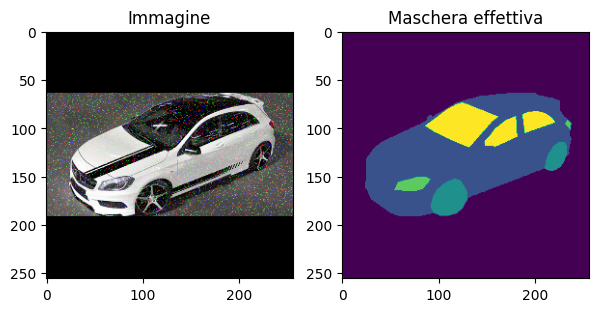

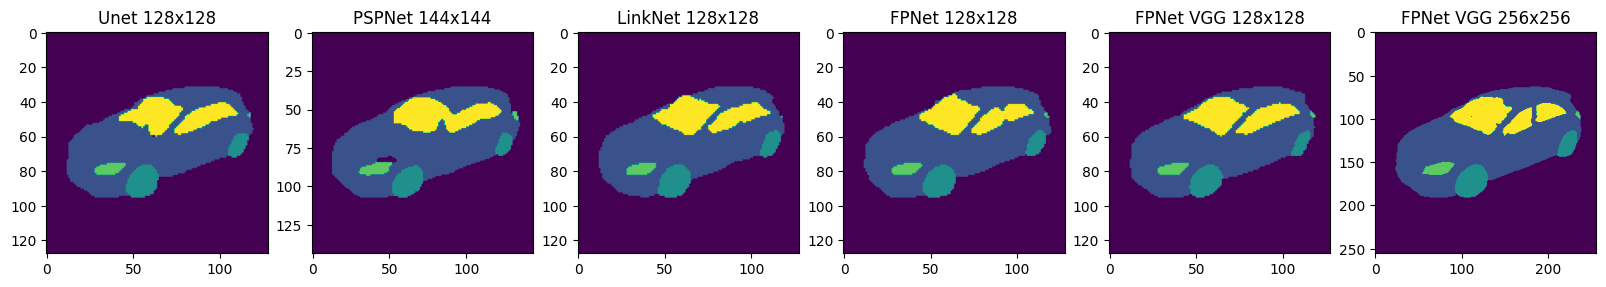

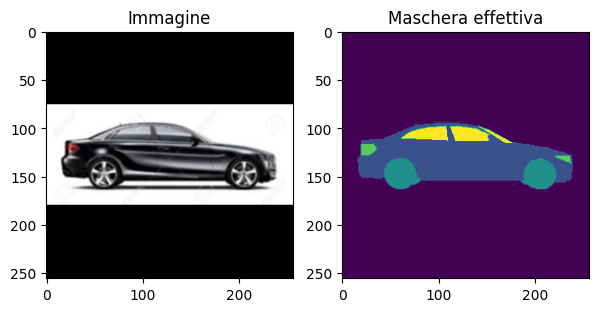

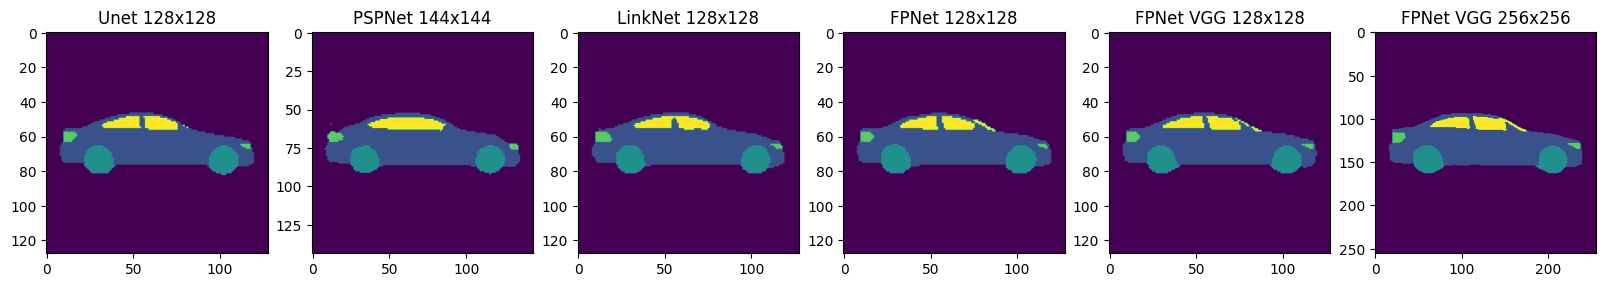

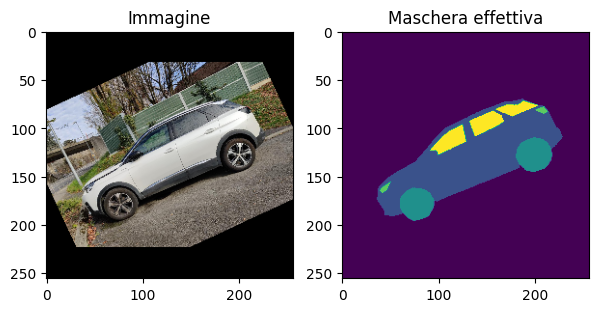

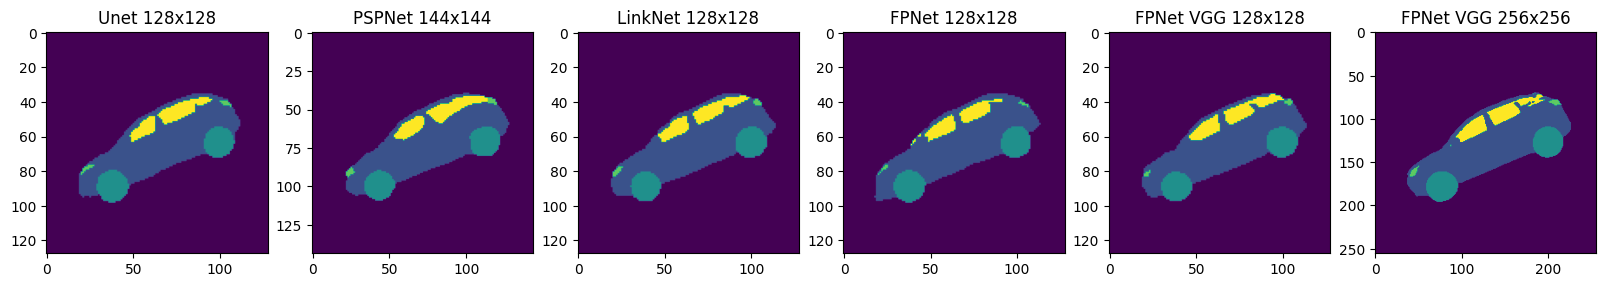

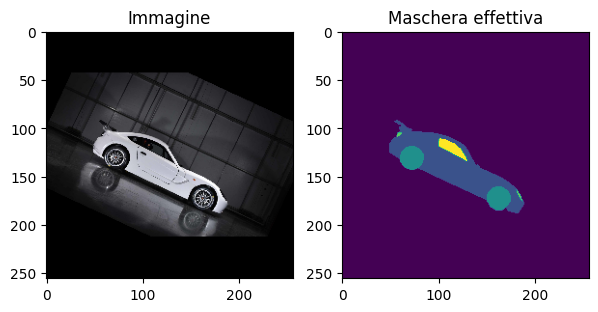

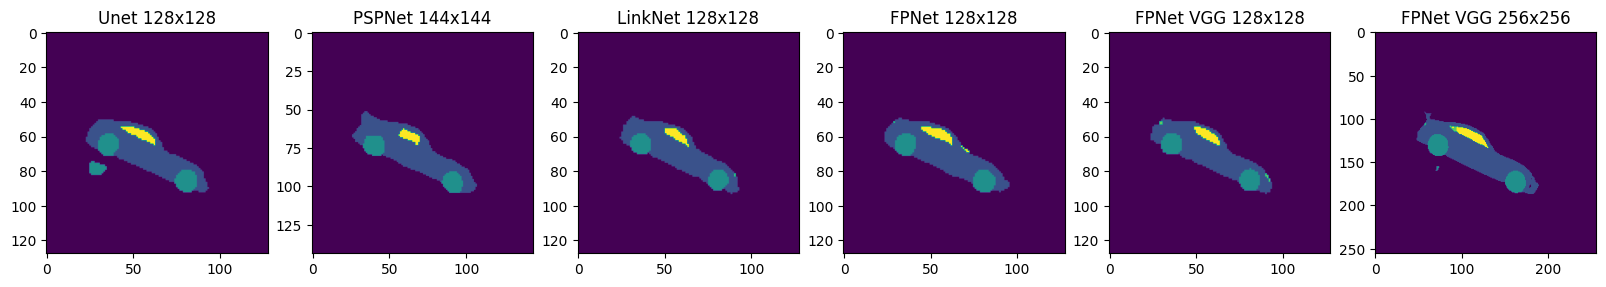

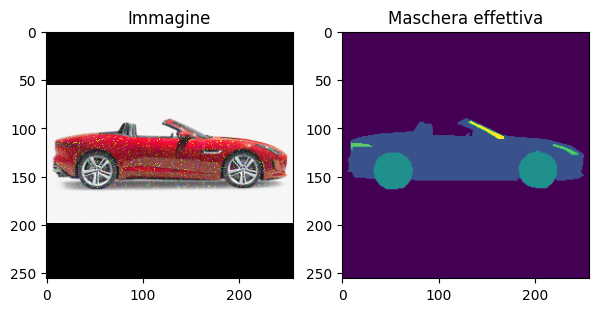

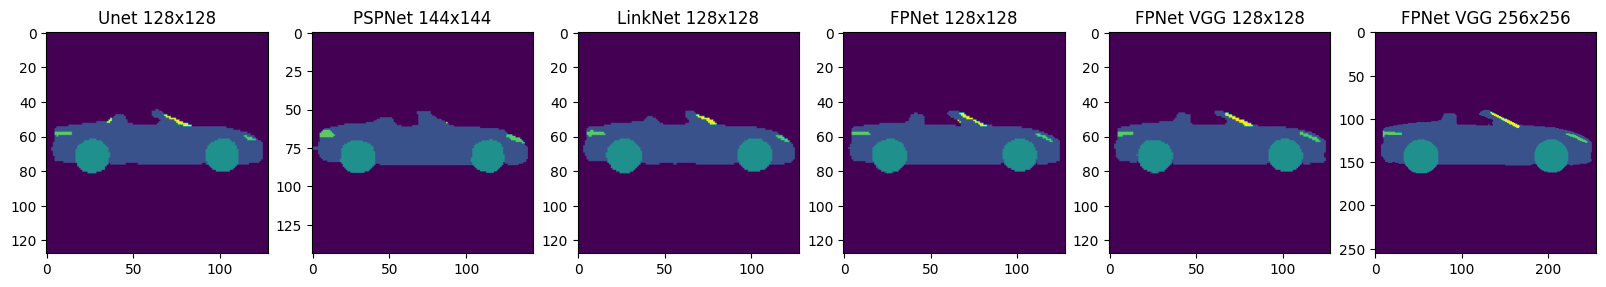

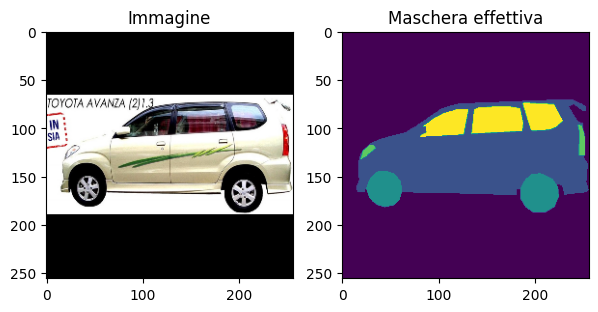

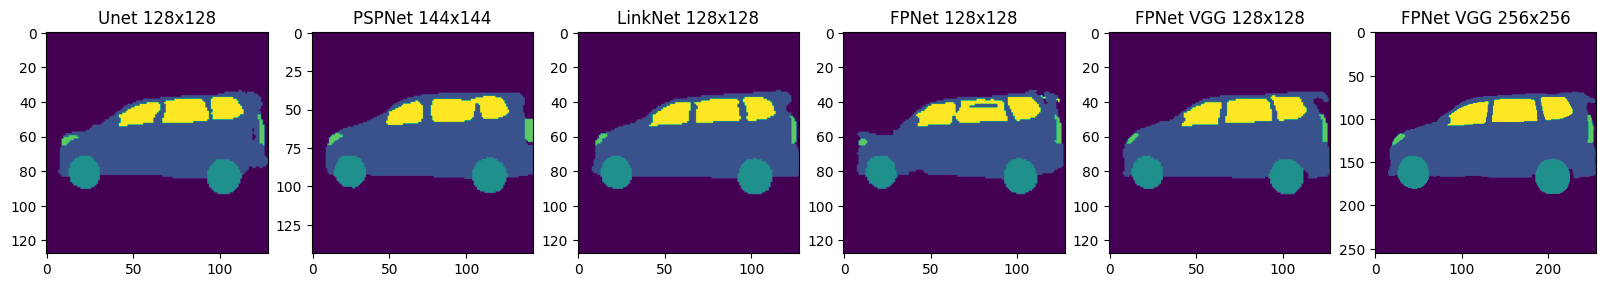

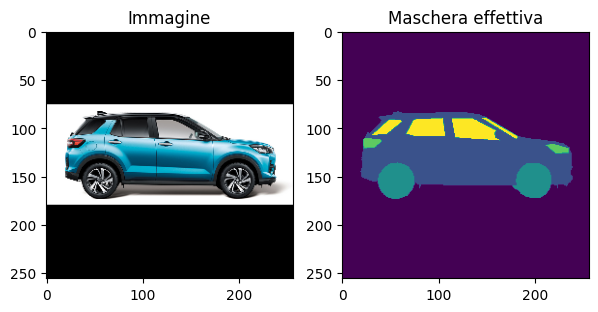

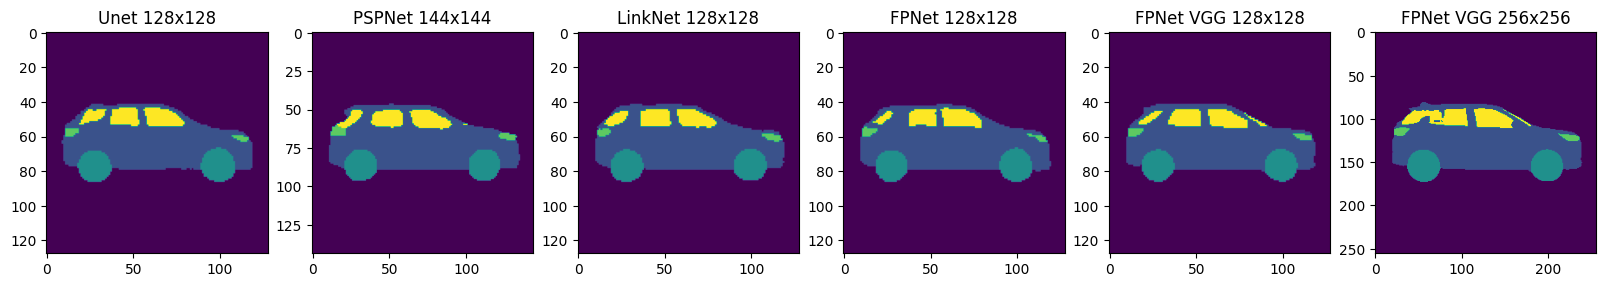

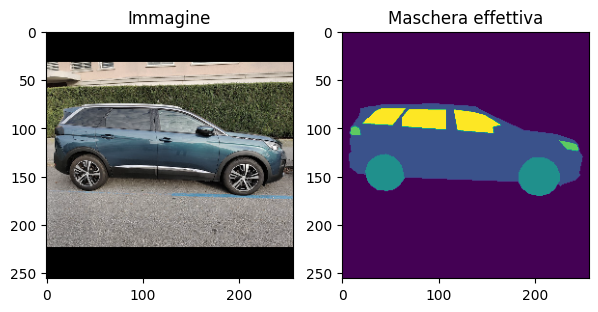

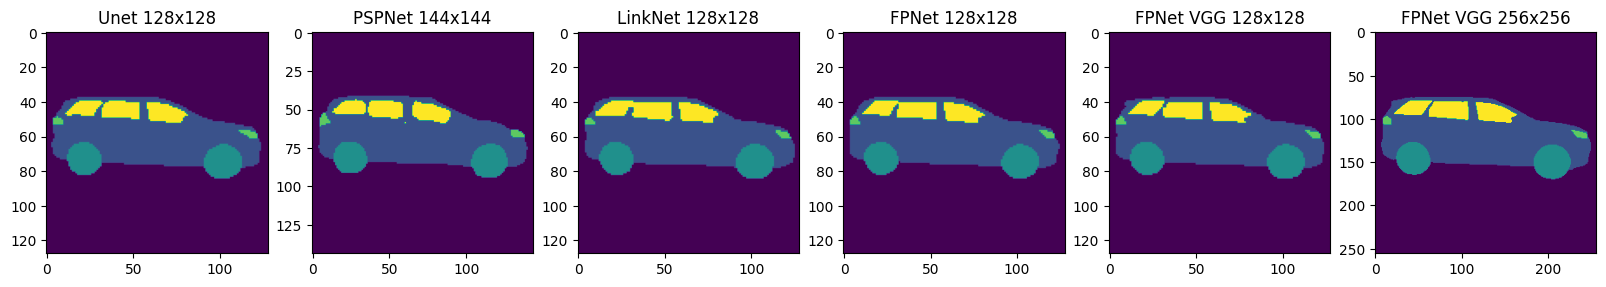

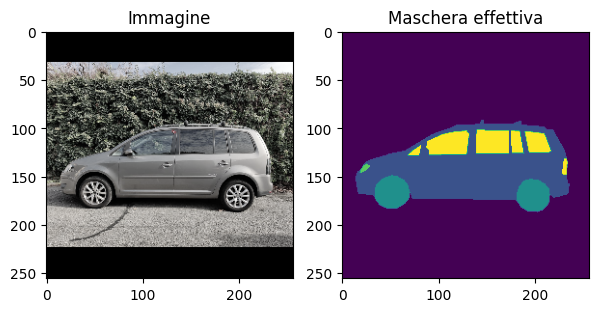

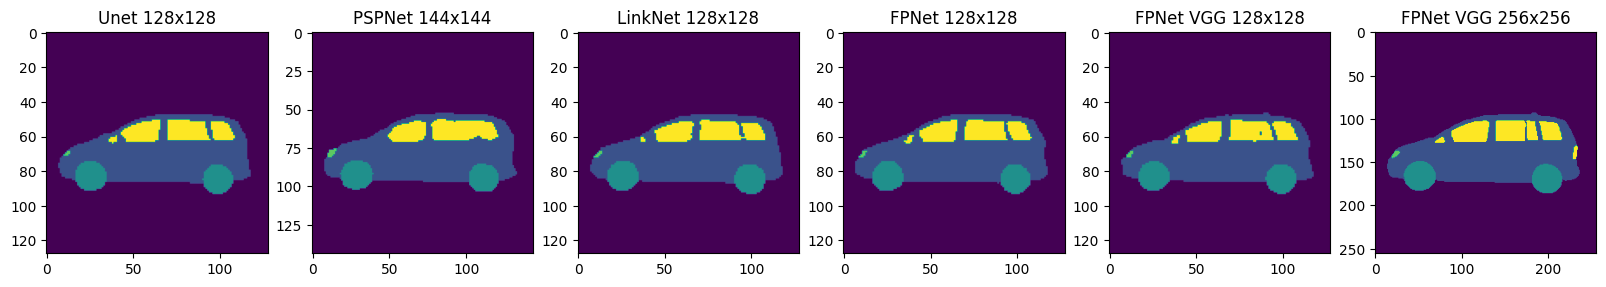

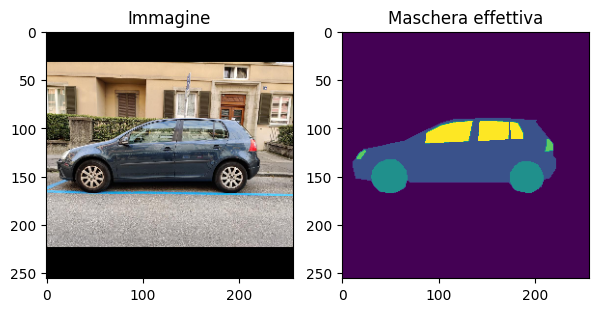

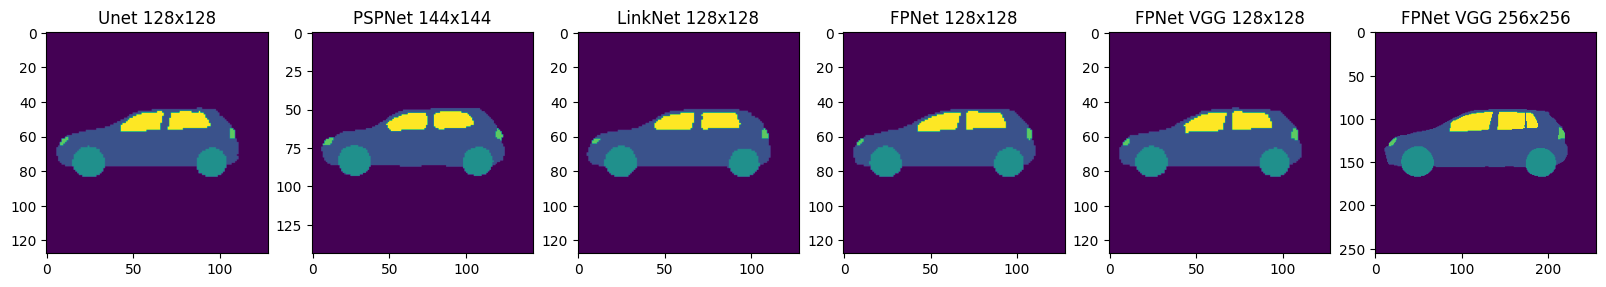

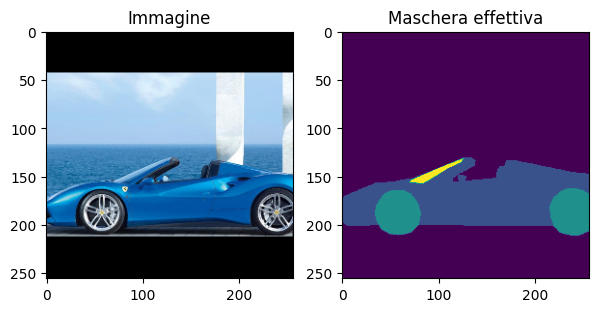

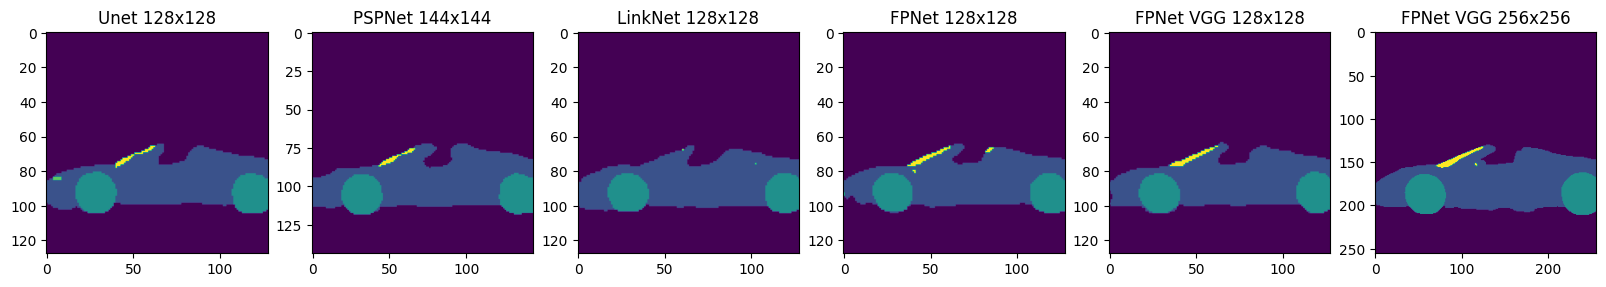

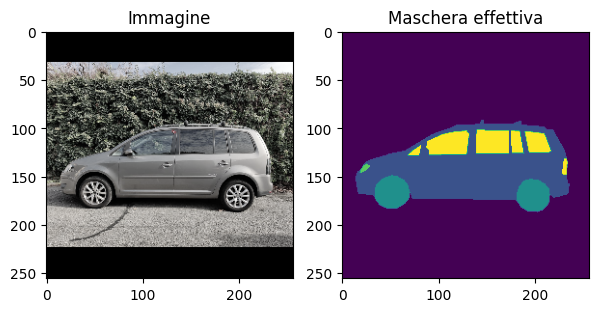

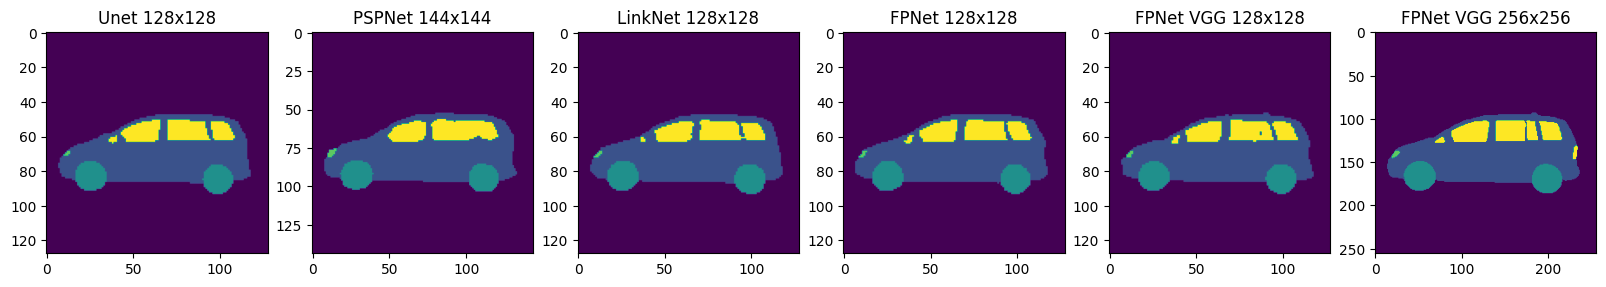

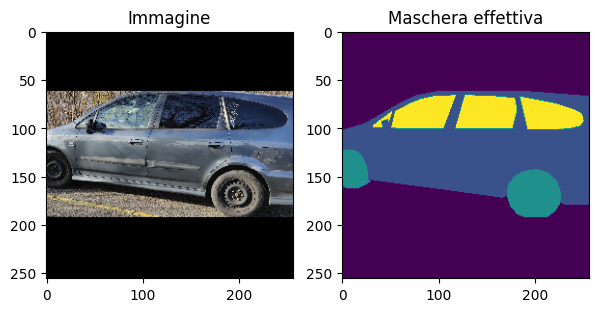

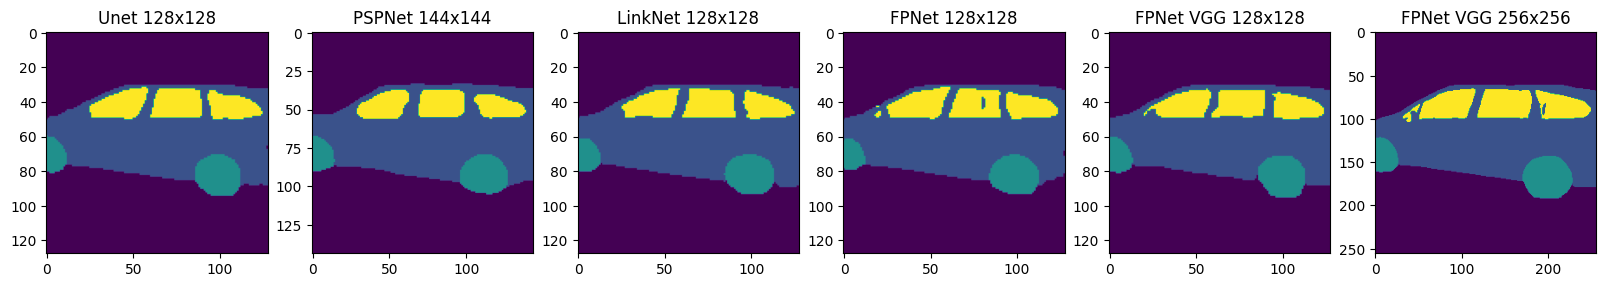

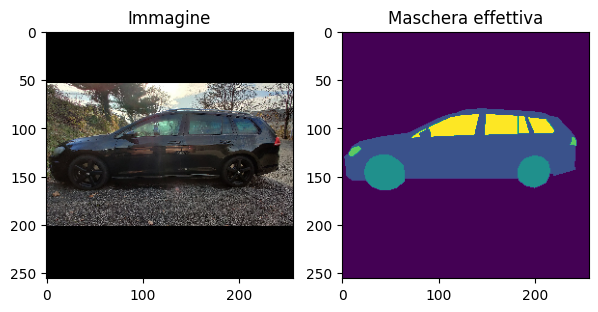

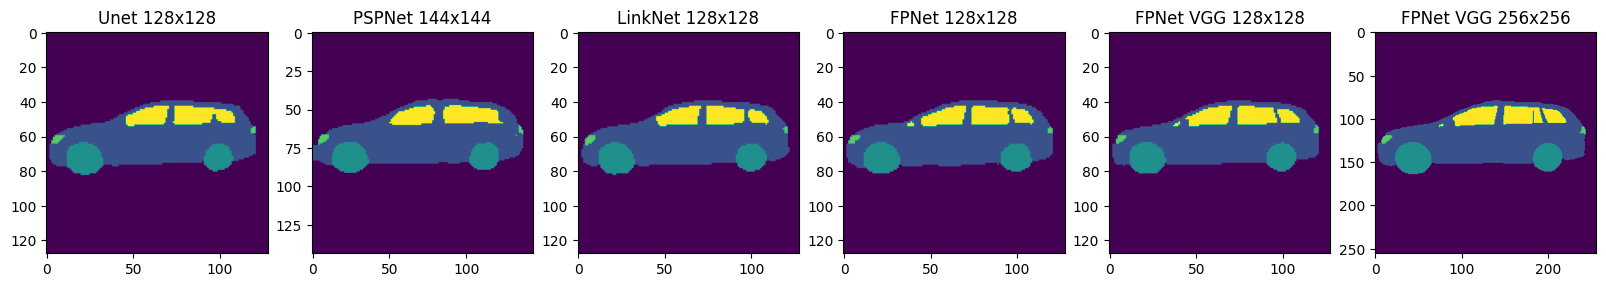

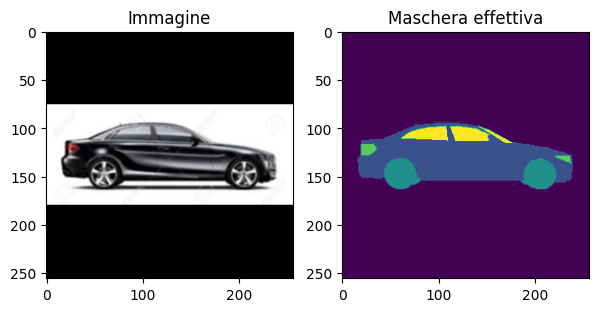

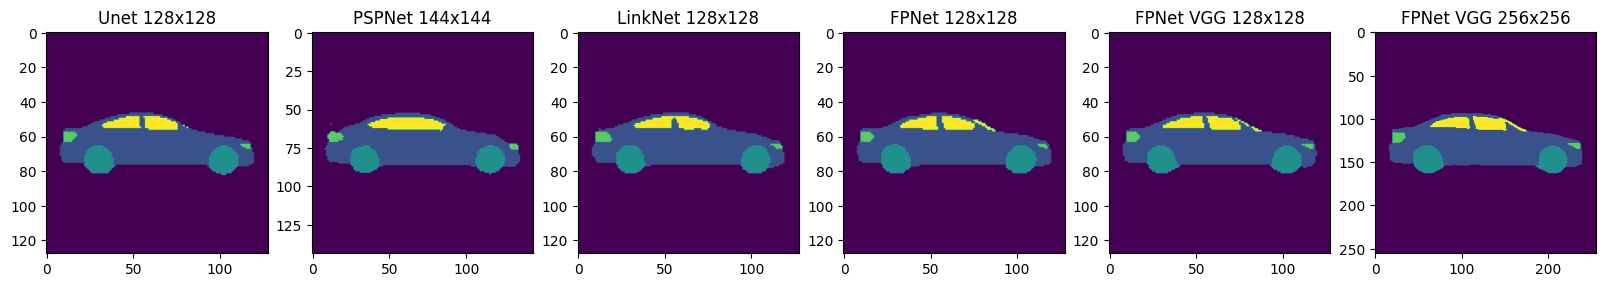

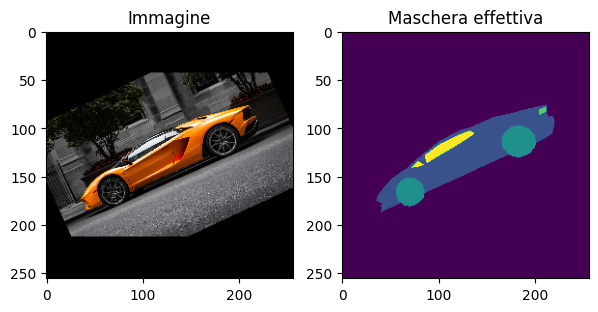

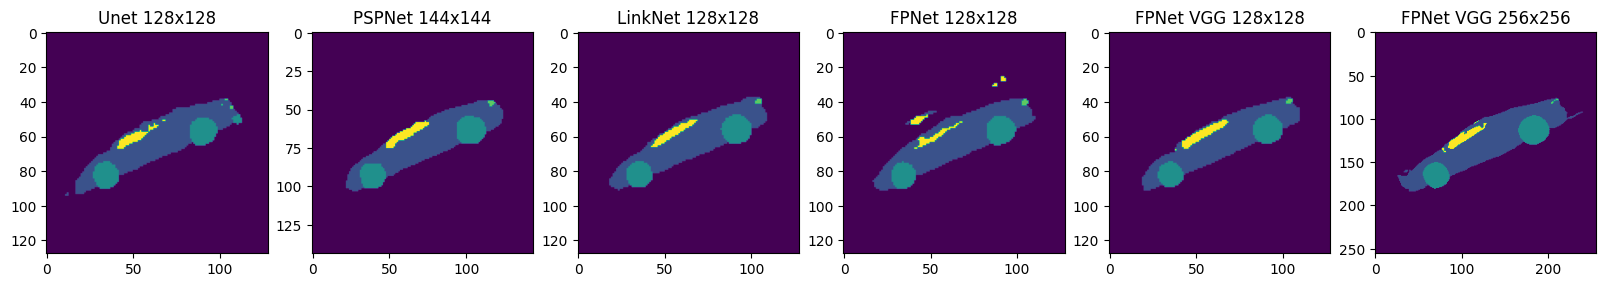

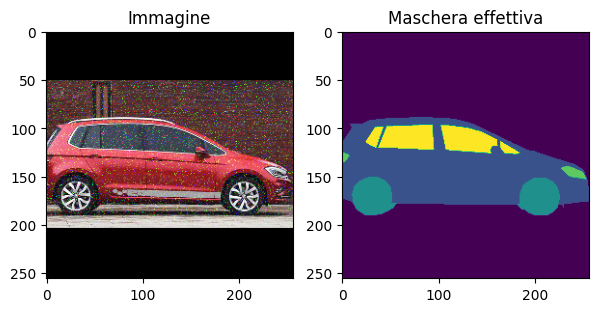

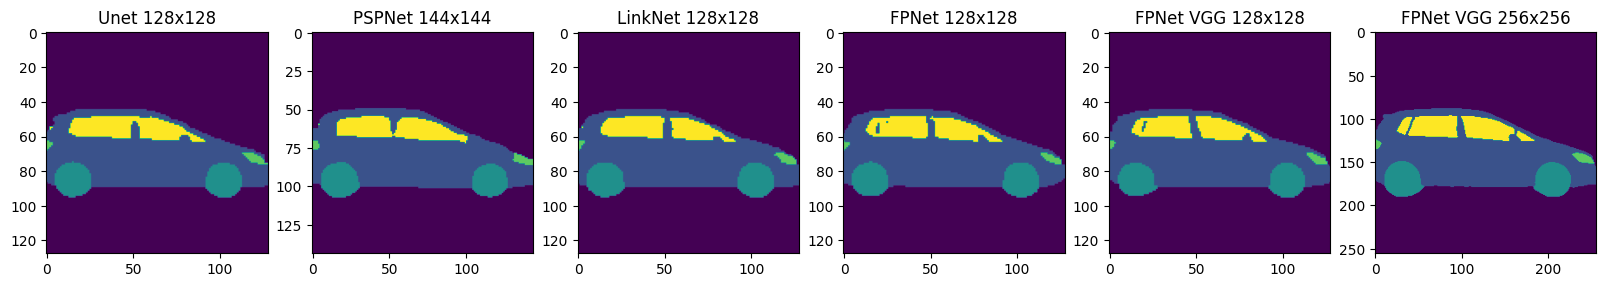

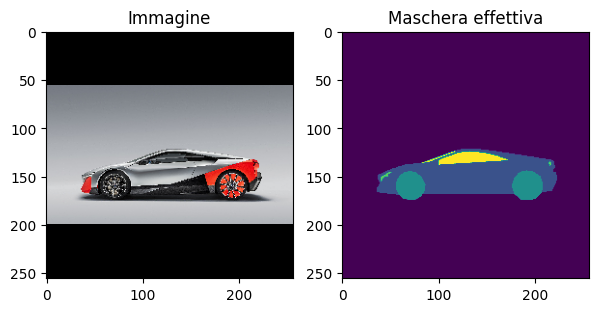

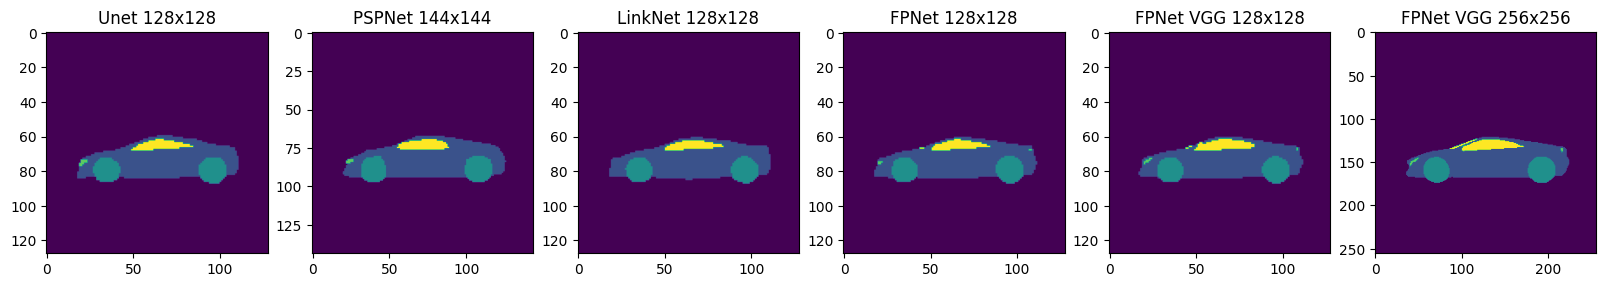

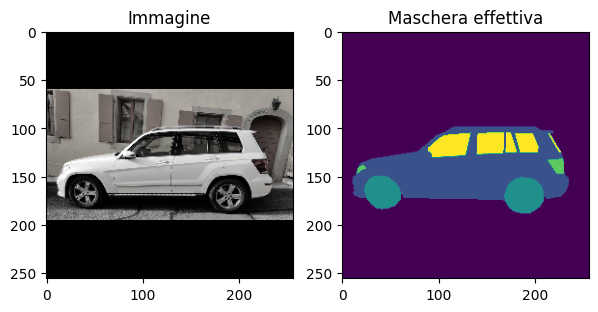

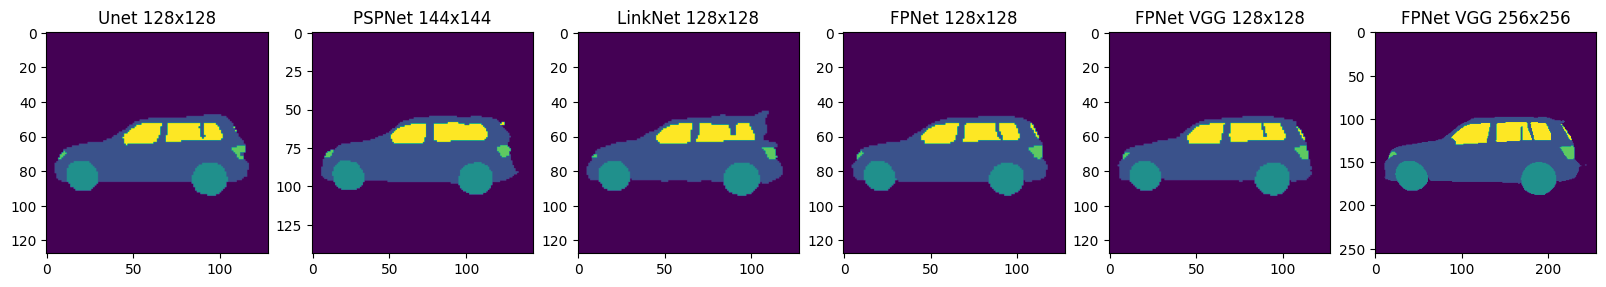

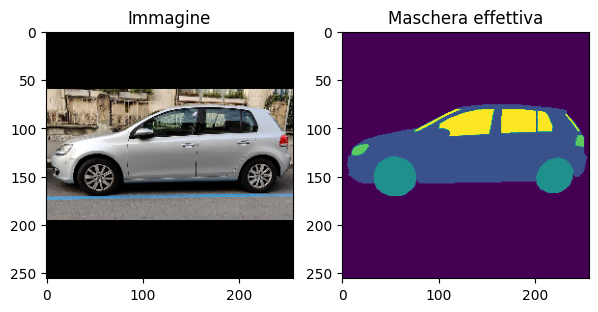

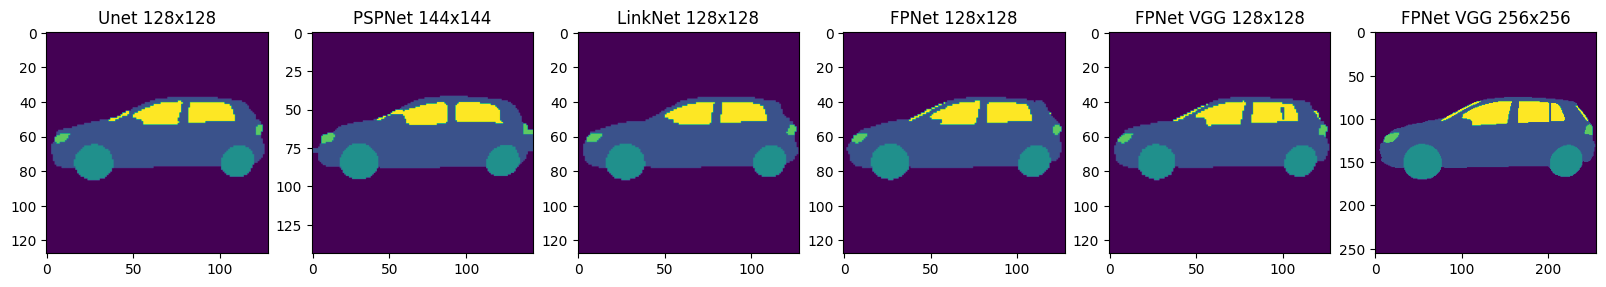

In [14]:
import random
for i in range(0,20):
    number = random.randint(0, len(X_test)-1)
    img = X_test[number]
    img_144 = X_test_144[number]
    img_256 = X_test_256[number]
    #Seleziono la sua maschera
    ground_truth=y_test_256[number]

    fig = plt.figure(figsize=(7, 7))

    #Immagine effettiva
    img_reale = cv2.cvtColor(img_256, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(1,2,1)
    plt.title('Immagine')
    plt.imshow(img_reale)

    #Maschera reale
    ax = fig.add_subplot(1,2,2)
    plt.title('Maschera effettiva')
    plt.imshow(ground_truth)

    #PREDICO LE VARIE MASCHERE
    fig = plt.figure(figsize=(20, 20))
    test_img = X_test_pro[number]
    test_img_input = np.expand_dims(test_img,0)

    test_img_144 = X_test_pro_144[number]
    test_img_input_144 = np.expand_dims(test_img_144,0)

    test_img_256 = X_test_pro_256[number]
    test_img_input_256 = np.expand_dims(test_img_256,0)

    #1) UNET
    prediction = (unet.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] 

    ax = fig.add_subplot(1,6,1)
    plt.title('Unet 128x128')
    plt.imshow(predicted_img)

    #2) PSPNET
    prediction = (psp.predict(test_img_input_144))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] 

    ax = fig.add_subplot(1,6,2)
    plt.title('PSPNet 144x144')
    plt.imshow(predicted_img)

    #3) LinkNet
    prediction = (linknet.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] 

    ax = fig.add_subplot(1,6,3)
    plt.title('LinkNet 128x128')
    plt.imshow(predicted_img)

    #4) FPNet
    prediction = (fpn.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] 

    ax = fig.add_subplot(1,6,4)
    plt.title('FPNet 128x128')
    plt.imshow(predicted_img)

    #5) FPNet VGG16
    test_img = X_test_pro_vgg[number]
    test_img_input = np.expand_dims(test_img,0)

    prediction = (fpnvgg.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] 

    ax = fig.add_subplot(1,6,5)
    plt.title('FPNet VGG 128x128')
    plt.imshow(predicted_img)

    #6) FPNet VGG16 256X256
    test_img = X_test_pro_256_vgg[number]
    test_img_input = np.expand_dims(test_img,0)

    prediction = (fpnvgg256.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] 

    ax = fig.add_subplot(1,6,6)
    plt.title('FPNet VGG 256x256')
    plt.imshow(predicted_img)



   